# Midterm Assignment

Expectations for Midterm:


*   Clean Diabetes dataset using tidy data principles. There is not a lot of cleaning necessary but think about what each column means. Do they make sense?
*   **You will need to wrangle continuous columns into categorical ones that make sense. Make sure you cite why you did what you did.**
*   Conduct Exploratory Data Analysis using Visualizations and t-tests to test your initial hypotheses/research questions. Your RQs can and will morph and change appropriately as you go through the process of analysis.
*   Conduct Multiple Linear Regression and ANOVA modeling on the dataset. What do each modeling step reveal?
*   I am more concerned with your process than than specific right outcomes (though of course, they are secondarily important)
*   **Write up:** Write in detail the steps that you took to clean the data and why. Justify why you think your model is the right solution. If you feel like there were solutions that you identified but couldn't achieve, please write that out as well. There are no page limits.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Cleaning

In [2]:
# loading the dataset 
df = pd.read_csv('diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [4]:
# check missing value
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
# check 0 value
(df == 0).sum() 

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### Replace 0 value with average of the column

In [6]:
# list all variables that should not be 0
columns = df.columns
columns = columns.drop('Pregnancies')
columns = columns.drop('DiabetesPedigreeFunction')
columns = columns.drop('Age')
columns = columns.drop('Outcome')
columns

Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], dtype='object')

In [7]:
# count outcome result
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [8]:
# function to get average of a column
# outcome = 0 or 1
def get_avg(col,outcome):
  temp = df[df["Outcome"] == outcome]
  if (outcome == 0):# calculate average when outcome = 0
    n = 500 - (temp[col] == 0).sum()
    avg = temp[col].sum() / n
  if (outcome == 1):# calculate average when outcome = 0
    n = 268 - (temp[col] == 0).sum()
    avg = temp[col].sum() / n
  return (avg)

In [9]:
get_avg("Glucose",1)

142.31954887218046

In [10]:
# replace 0 value
for col in columns:
  df.loc[(df['Outcome'] == 0 ) & (df[col] == 0), col] = get_avg(col,0)
  df.loc[(df['Outcome'] == 1 ) & (df[col] == 0), col] = get_avg(col,1)

In [11]:
# check 0 value
(df == 0).sum() 

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [12]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            6    148.0           72.0           35.0  206.846154  33.6   
1            1     85.0           66.0           29.0  130.287879  26.6   
2            8    183.0           64.0           33.0  206.846154  23.3   
3            1     89.0           66.0           23.0   94.000000  28.1   
4            0    137.0           40.0           35.0  168.000000  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

### Wrangle continuous columns into categorical

In [13]:
# statistic of dataframe
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.697358      72.428141      29.247042  157.003527   
std       3.369578   30.462008      12.106044       8.923908   88.860914   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      28.000000  130.287879   
75%       6.000000  141.000000      80.000000      33.000000  206.846154   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

             BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.00000                768.000000  768.000000  768.000000  
mean    32.44642                  0.471876   33.240885    0.348958  
std      6.87897                  0.331329   11.760232    0.476951  
min     18.20000                  0.078000   21.000000    0.000000  
25%     27.50000                  0.243750   24.000000    0.000000  
50%     32.05000                  0.372500   29.000000    0.000000  
75%     36.60000                  0.626250   41.000000    1.000000  
max     67.10000                  2.420000   81.000000    1.000000

In [14]:
# transform into categorical
df["Pregnancies_level"] = pd.cut(df.Pregnancies,bins=[-1,1,3,6,17],
            labels=['level 1','level 2','level 3','level 4'])
df["Glucose_group"] = pd.cut(df.Glucose,bins=[0,99.75,117,141,199],
            labels=['extremely low','low','high','extremely high'])
df["BloodPressure_group"] = pd.cut(df.BloodPressure,bins=[0,64,72,80,122],
            labels=['extremely low','low','high','extremely high'])
df["SkinThickness_group"] = pd.cut(df.SkinThickness,bins=[0,25,28,33,99],
            labels=['extremely thin','thin','thick','extremely thick'])
df["Insulin_group"] = pd.cut(df.Insulin,bins=[0,121,130,206,846],
            labels=['extremely low','low','high','extremely high'])
df["BMI_group"] = pd.cut(df.BMI,bins=[0,32,68],
            labels=['below avg','above avg'])
df["DPF_group"] = pd.cut(df.DiabetesPedigreeFunction,bins=[0,0.243750,0.372500,0.626250,3],
            labels=['extremely low','low','high','extremely high'])
df["Age_group"] = pd.cut(df.Age,bins=[0,30,40,50,60,70,81],
            labels=['20s','30s','40s','50s','60s','70s'])

In [15]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            6    148.0           72.0           35.0  206.846154  33.6   
1            1     85.0           66.0           29.0  130.287879  26.6   
2            8    183.0           64.0           33.0  206.846154  23.3   
3            1     89.0           66.0           23.0   94.000000  28.1   
4            0    137.0           40.0           35.0  168.000000  43.1   

   DiabetesPedigreeFunction  Age  Outcome Pregnancies_level   Glucose_group  \
0                     0.627   50        1           level 3  extremely high   
1                     0.351   31        0           level 1   extremely low   
2                     0.672   32        1           level 4  extremely high   
3                     0.167   21        0           level 1   extremely low   
4                     2.288   33        1           level 1            high   

  BloodPressure_group SkinThickness_group   Insulin_group  BMI_group  \
0                 low     extremely thick  extremely high  above avg   
1                 low               thick            high  below avg   
2       extremely low               thick  extremely high  below avg   
3                 low      extremely thin   extremely low  below avg   
4       extremely low     extremely thick            high  above avg   

        DPF_group Age_group  
0  extremely high       40s  
1             low       30s  
2  extremely high       30s  
3   extremely low       20s  
4  extremely high       30s

In [16]:
# drop original columns
df_new = df[['Pregnancies_level','Glucose_group',
       'BloodPressure_group','SkinThickness_group','Insulin_group',
       'BMI_group','DPF_group','Age_group','Outcome']]
df_new.head()

Pregnancies_level   Glucose_group BloodPressure_group SkinThickness_group  \
0           level 3  extremely high                 low     extremely thick   
1           level 1   extremely low                 low               thick   
2           level 4  extremely high       extremely low               thick   
3           level 1   extremely low                 low      extremely thin   
4           level 1            high       extremely low     extremely thick   

    Insulin_group  BMI_group       DPF_group Age_group  Outcome  
0  extremely high  above avg  extremely high       40s        1  
1            high  below avg             low       30s        0  
2  extremely high  below avg  extremely high       30s        1  
3   extremely low  below avg   extremely low       20s        0  
4            high  above avg  extremely high       30s        1

## Exploratory Data Analysis

Is there a statistically significant difference between the ages of those with or without diabetes?¶

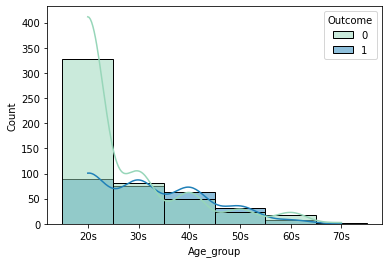

In [17]:
# histogram visualization
sns.histplot(data=df_new, x="Age_group", hue="Outcome",kde=True,palette="YlGnBu")

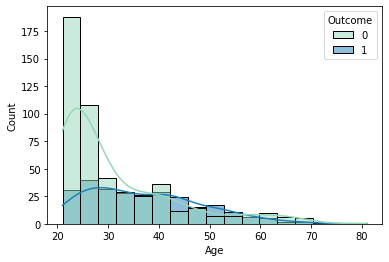

In [18]:
# histogram visualization on original dataframe
sns.histplot(data=df, x="Age", hue="Outcome",kde=True,palette="YlGnBu")

In [19]:
# t-test
res = st.ttest_ind(df.query('Outcome == 0')['Age'],
                   df.query('Outcome == 1')['Age'],
                   equal_var=True)
display(res)

Ttest_indResult(statistic=-6.792688071649956, pvalue=2.2099754606654358e-11)

## Encoding

In [20]:
df["Pregnancies_level"] = pd.cut(df.Pregnancies,bins=[-1,1,3,6,17],
            labels=[1,2,3,4])
df["Glucose_group"] = pd.cut(df.Glucose,bins=[0,99.75,117,141,199],
            labels=[1,2,3,4])
df["BloodPressure_group"] = pd.cut(df.BloodPressure,bins=[0,64,72,80,122],
            labels=[1,2,3,4])
df["SkinThickness_group"] = pd.cut(df.SkinThickness,bins=[0,25,28,33,99],
            labels=[1,2,3,4])
df["Insulin_group"] = pd.cut(df.Insulin,bins=[0,121,130,206,846],
            labels=[1,2,3,4])
df["BMI_group"] = pd.cut(df.BMI,bins=[0,32,68],
            labels=[0,1])
df["DPF_group"] = pd.cut(df.DiabetesPedigreeFunction,bins=[0,0.243750,0.372500,0.626250,3],
            labels=[1,2,3,4])
df["Age_group"] = pd.cut(df.Age,bins=[0,30,40,50,60,70,81],
            labels=[1,2,3,4,5,6])

In [21]:
df_encoding = df[['Pregnancies_level','Glucose_group',
       'BloodPressure_group','SkinThickness_group','Insulin_group',
       'BMI_group','DPF_group','Age_group','Outcome']]
df_encoding.head()

Pregnancies_level Glucose_group BloodPressure_group SkinThickness_group  \
0                 3             4                   2                   4   
1                 1             1                   2                   3   
2                 4             4                   1                   3   
3                 1             1                   2                   1   
4                 1             3                   1                   4   

  Insulin_group BMI_group DPF_group Age_group  Outcome  
0             4         1         4         3        1  
1             3         0         2         2        0  
2             4         0         4         2        1  
3             1         0         1         1        0  
4             3         1         4         2        1

In [22]:
df_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Pregnancies_level    768 non-null    category
 1   Glucose_group        768 non-null    category
 2   BloodPressure_group  768 non-null    category
 3   SkinThickness_group  768 non-null    category
 4   Insulin_group        768 non-null    category
 5   BMI_group            768 non-null    category
 6   DPF_group            768 non-null    category
 7   Age_group            768 non-null    category
 8   Outcome              768 non-null    int64   
dtypes: category(8), int64(1)
memory usage: 13.7 KB


## Multiple Linear Regression

In [23]:
X = df_encoding[['Pregnancies_level','Glucose_group',
       'BloodPressure_group','SkinThickness_group','Insulin_group',
       'BMI_group','DPF_group','Age_group']]
y = df_encoding['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
# train model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

Multiple Linear Regression accuracy: 0.786


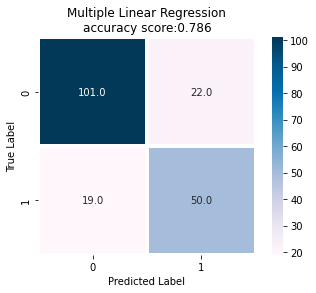

In [25]:
# make prediction
y_pred = np.around(regr.predict(X_test))

acc=round(accuracy_score(y_test,y_pred),3)
print('Multiple Linear Regression accuracy:',acc)

#confusion matrix
cm = confusion_matrix
cm1 = cm(y_test,y_pred)
sns.heatmap(cm1,annot=True,fmt=".1f",linewidths=3,square=True,cmap='PuBu',color="#cd1076")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Multiple Linear Regression\naccuracy score:{0}'.format(acc),size=12)
plt.show()

In [26]:
# test 1
prediction = regr.predict([[3,4,2,4,4,1,4,3]])
print(prediction)

[0.96160423]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [27]:
# test 2
prediction = regr.predict([[1,3,2,2,1,0,1,1]])
print(prediction)

[0.04798461]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


## ANOVA

### One Way ANOVA

In [28]:
st.f_oneway(df['Age'][df['Outcome'] == 0],
               df['Age'][df['Outcome'] == 1])

F_onewayResult(statistic=46.14061123873557, pvalue=2.2099754606650332e-11)

In [29]:
lm = sfa.ols('Outcome ~ C(Age_group)', data=df_encoding).fit()

In [30]:
# print summary of linear regression
(lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     18.29
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           3.58e-17
Time:                        00:53:27   Log-Likelihood:                -477.14
No. Observations:                 768   AIC:                             966.3
Df Residuals:                     762   BIC:                             994.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2158      0.022      9.748      0.000       0.172       0.259
C(Age_group)[T.2]     0.2682      0.042      6.336      0.000       0.185       0.351
C(Age_group)[T.3]     0.3505      0.048      7.310      0.000       0.256       0.445
C(Age_group)[T.4]     0.3582      0.065      5.478      0.000       0.230       0.487
C(Age_group)[T.5]     0.0642      0.093      0.689      0.491      -0.119       0.247
C(Age_group)[T.6]    -0.2158      0.320     -0.673      0.501      -0.845       0.413
==============================================================================
Omnibus:                      510.153   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.271
Skew:                           0.541   Prob(JB):                     1.36e-18
Kurtosis:                       1.816   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#Show Anova table
anova_table = sa.stats.anova_lm(lm)
print(anova_table)

                 df      sum_sq   mean_sq          F        PR(>F)
C(Age_group)    5.0   18.697520  3.739504  18.291642  3.576660e-17
Residual      762.0  155.781647  0.204438        NaN           NaN


In [32]:
# Post hoc test
sp.posthoc_ttest(df_encoding, val_col='Outcome', group_col='Age_group', p_adjust='holm')

3             2             1             4         5    6
3  1.000000e+00  1.000000e+00  1.347993e-12  1.000000e+00  0.111533  1.0
2  1.000000e+00  1.000000e+00  1.921430e-09  1.000000e+00  0.575396  1.0
1  1.347993e-12  1.921430e-09  1.000000e+00  1.129863e-07  1.000000  1.0
4  1.000000e+00  1.000000e+00  1.129863e-07  1.000000e+00  0.161066  1.0
5  1.115330e-01  5.753965e-01  1.000000e+00  1.610665e-01  1.000000  1.0
6  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000  1.0